In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    auc, confusion_matrix, classification_report
)

In [5]:
import joblib
import os

In [6]:
plt.style.use('ggplot')
os.makedirs('../models', exist_ok=True)

print("Modeling Environment Ready.")

Modeling Environment Ready.


In [7]:
df = pd.read_csv('../data/features_final.csv')

In [8]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

print(f"Features: {X.shape[1]}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Features: 13
Target distribution:
loan_status
1    0.608
0    0.392
Name: proportion, dtype: float64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 8000
Test set size: 2000


In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
lr_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'class_weight': ['balanced'], # Handles the 39% minority class
    'solver': ['liblinear']
}

In [12]:
lr_search = GridSearchCV(LogisticRegression(random_state=42), lr_grid, cv=5, scoring='roc_auc')
lr_search.fit(X_train, y_train)

e:\Loan approval system\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
e:\Loan approval system\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
e:\Loan approval system\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, l

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'class_weight': ['balanced'], 'penalty': ['l2'], 'solver': ['liblinear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displ

In [13]:
best_lr = lr_search.best_estimator_
lr_probs = best_lr.predict_proba(X_test)[:, 1]

print(f"Best LR Parameters: {lr_search.best_params_}")

Best LR Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [14]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
imbalance_weight = neg_count / pos_count

In [15]:
xgb_model = XGBClassifier(
    scale_pos_weight=imbalance_weight, 
    n_estimators=300,        
    max_depth=4,             
    learning_rate=0.05,     
    subsample=0.8,          
    colsample_bytree=0.8,   
    min_child_weight=5,      
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [16]:
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print(f"XGBoost trained with scale_pos_weight: {imbalance_weight:.2f}")

e:\Loan approval system\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [10:25:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained with scale_pos_weight: 0.64


In [17]:
def evaluate_model(y_real, y_predicted_probs, name):

    fpr, tpr, _ = roc_curve(y_real, y_predicted_probs)
    roc_auc = auc(fpr, tpr)

In [18]:
def evaluate_model(y_real, y_predicted_probs, name):
    fpr, tpr, _ = roc_curve(y_real, y_predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_real, y_predicted_probs)
    pr_auc = auc(recall, precision)
    
    print(f"--- {name} Results ---")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}\n")
    
    return fpr, tpr, roc_auc, recall, precision, pr_auc

In [19]:
lr_res = evaluate_model(y_test, lr_probs, "Logistic Regression")
xgb_res = evaluate_model(y_test, xgb_probs, "XGBoost")

--- Logistic Regression Results ---
ROC-AUC: 0.8136
PR-AUC:  0.8736

--- XGBoost Results ---
ROC-AUC: 0.8314
PR-AUC:  0.8903



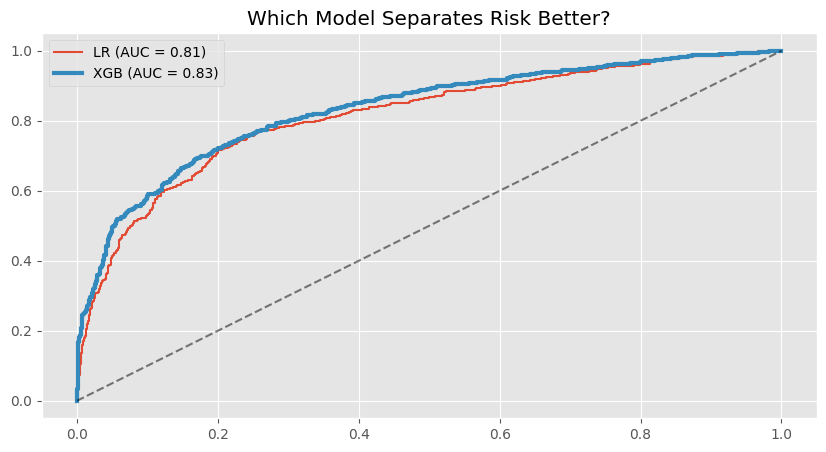

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(lr_res[0], lr_res[1], label=f'LR (AUC = {lr_res[2]:.2f})')
plt.plot(xgb_res[0], xgb_res[1], label=f'XGB (AUC = {xgb_res[2]:.2f})', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('Which Model Separates Risk Better?')
plt.legend()
plt.show()

In [21]:
from sklearn.calibration import calibration_curve

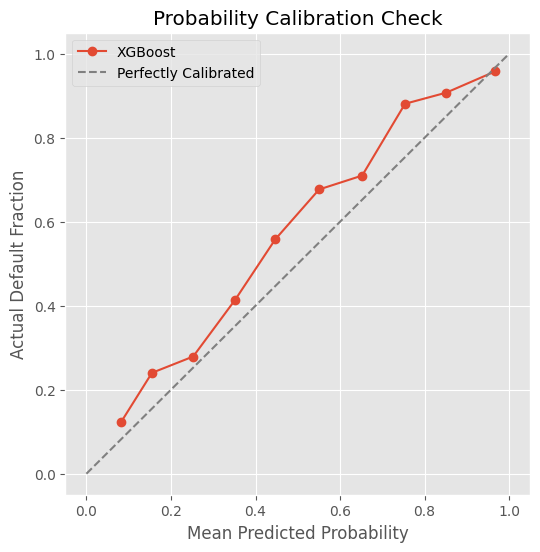

In [22]:
plt.figure(figsize=(6, 6))
prob_true, prob_pred = calibration_curve(y_test, xgb_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.title('Probability Calibration Check')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Default Fraction')
plt.legend()
plt.show()

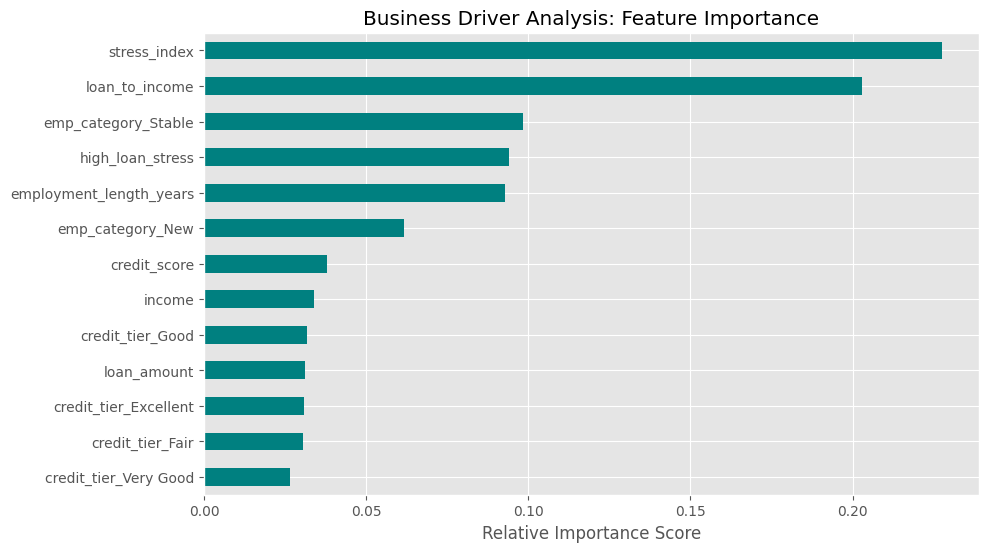

In [23]:
plt.figure(figsize=(10, 6))
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("Business Driver Analysis: Feature Importance")
plt.xlabel("Relative Importance Score")
plt.show()

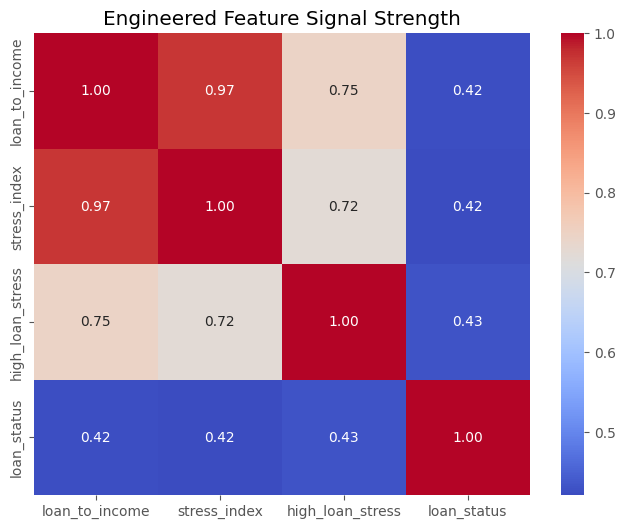

In [24]:
engineered_cols = ['loan_to_income', 'stress_index', 'high_loan_stress', 'loan_status']
plt.figure(figsize=(8, 6))
sns.heatmap(df[engineered_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Engineered Feature Signal Strength")
plt.show()

In [25]:
from sklearn.metrics import precision_recall_curve

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)

In [27]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Probability Threshold: {best_threshold:.4f}")

Optimal Probability Threshold: 0.3550


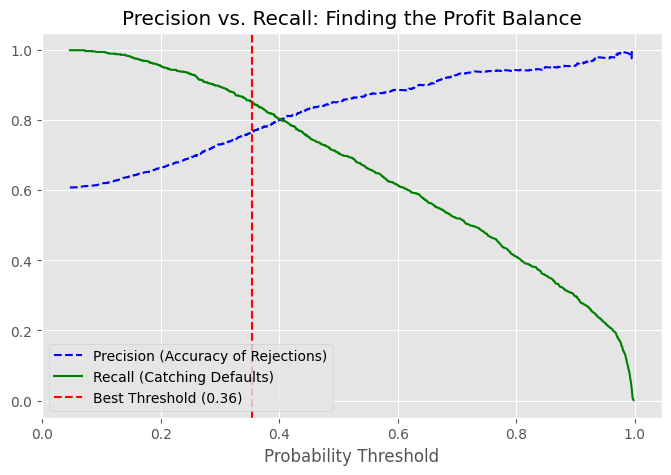

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision (Accuracy of Rejections)')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall (Catching Defaults)')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Probability Threshold')
plt.title('Precision vs. Recall: Finding the Profit Balance')
plt.legend()
plt.show()

In [29]:
import joblib

In [30]:
joblib.dump(xgb_model, '../models/loan_model.pkl')

['../models/loan_model.pkl']

In [31]:
joblib.dump(best_threshold, '../models/approval_threshold.pkl')

['../models/approval_threshold.pkl']

In [32]:
joblib.dump(list(X.columns), '../models/model_columns.pkl')

print(" ALL ARTIFACTS SAVED SUCCESSFULLY.")
print(f"Model: XGBoost (Winner)")
print(f"Decision Threshold: {best_threshold:.2f}")

 ALL ARTIFACTS SAVED SUCCESSFULLY.
Model: XGBoost (Winner)
Decision Threshold: 0.36
